In [63]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
df=pd.read_csv("183063h.csv")
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

,avgMeasuredTime,avgSpeed,vehicleCount,Day sin,Day cos,Year sin,Year cos
0,94.333333,44.166667,37,1.305262e-01,-0.991445,0.684297,0.729203
1,104.750000,39.666667,99,5.591821e-12,-1.000000,0.684558,0.728958
2,111.333333,37.416667,136,-2.588190e-01,-0.965926,0.685081,0.728467
3,128.500000,32.083333,150,-5.000000e-01,-0.866025,0.685603,0.727976
4,107.250000,39.250000,125,-7.071068e-01,-0.707107,0.686124,0.727484


In [65]:
#Normalize the data
mean = df.mean()
std = df.std()
df = (df - mean) / std
df.head()

,avgMeasuredTime,avgSpeed,vehicleCount,Day sin,Day cos,Year sin,Year cos
0,-0.438201,0.164485,-0.208904,0.183409,-1.395105,0.742746,1.777563
1,0.153914,-0.389065,1.353849,-0.001508,-1.407180,0.743052,1.777070
2,0.528130,-0.665840,2.286459,-0.368176,-1.359085,0.743665,1.776081
3,1.503935,-1.321900,2.639339,-0.709857,-1.218078,0.744277,1.775092
4,0.296021,-0.440320,2.009197,-1.003265,-0.993768,0.744888,1.774102


In [66]:
def dnormal(x):return x*std.avgSpeed + mean.avgSpeed
mean.avgSpeed

42.829510785775696

In [67]:
#Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}
t=[]
n = len(df)
#train_df = df[0:int(n*0.8)]         #80% train
t.append(df[0:int(n*0.4)])
val_df = df[int(n*0.4):int(n*0.5)]
t.append(df[int(n*0.5):int(n*0.8)])           #10% validation
test_df = df[int(n*0.8):int(n*0.9)]
t.append(df[int(n*0.9):])             #10% test
train_df=pd.concat(t)
num_features = df.shape[1]

In [68]:
model=tf.keras.models.load_model("lstmmodel5")

In [69]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width-shift
    self.shift = shift

    self.total_window_size = input_width + label_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.shift_start = self.total_window_size - self.label_width - shift
    self.shift_end = self.total_window_size - self.label_width
    self.shift_slice = slice(self.shift_start, self.shift_end)
    self.shift_indices = np.arange(self.total_window_size)[self.shift_slice]


    self.label_start = self.input_width
    self.target_start = self.total_window_size - self.shift
    self.labels_slice = slice(self.label_start, None)
    self.targets_slice = slice(self.target_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    self.total_window_size = input_width + label_width # shift

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [70]:
#Split
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  tagets = features[:, self.targets_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  tagets.set_shape([None, self.shift, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [71]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=8,#1,
      shuffle=True,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [72]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result

  #print(result)
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [73]:
def plot(self, model=None, plot_col='avgSpeed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  ppre=[]
  llabels=[]

  for n in range(max_n):
    print("n=",n)
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    
    llabels.append(labels[n, :, label_col_index])
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      ppre.append(predictions[n, :, label_col_index])
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [H]')

  #return ppre,llabels

WindowGenerator.plot = plot

In [74]:
YT=[]
YP=[]
yt=[]
yp=[]
def plot2(self, model=None, plot_col='avgSpeed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    
    if model is not None:
      predictions = model(inputs)
      YT.append(labels[n, :, label_col_index])
      YP.append(predictions[n, :, label_col_index])
      
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [H]')

  for i in YT :
    for k in range(16,24):
      yt.append(float(i[k]))
      
  for i in YP :
    for k in range(16,24):
      yp.append(float(i[k]))

  return yt,yp

    

  

WindowGenerator.plot2 = plot2

In [75]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=24,
    label_columns=['avgSpeed'])

wide_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): ['avgSpeed']

In [76]:
def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=1000,
                      validation_data=window.val,callbacks=[early_stopping])
  return history

In [77]:
val_performance = {}
performance = {}

In [78]:
t,p=wide_window.plot2(model)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes at component 1: expected [?,0,1] but got [16,24,1]. [Op:IteratorGetNext]

In [79]:

YT=[]
YP=[]
yt=[]
yp=[]
from sklearn.metrics import r2_score
t,p=wide_window.plot2(model,max_subplots=50)
r2_score(t, p)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes at component 1: expected [?,0,1] but got [16,24,1]. [Op:IteratorGetNext]

In [44]:
OUT_STEPS = 8
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=4)#OUT_STEPS)

#multi_window.plot()
multi_window

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [28 29 30 31 32 33 34 35]
Label column name(s): None

In [45]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(OUT_STEPS*num_features*2),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [46]:
history = compile_and_fit(multi_lstm_model, multi_window)


val_performance['mLSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['mLSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Epoch 1/1000


ValueError: in user code:

    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 8 and 4 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_2/reshape_2/Reshape, IteratorGetNext:1)' with input shapes: [?,8,7], [?,4,7].


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

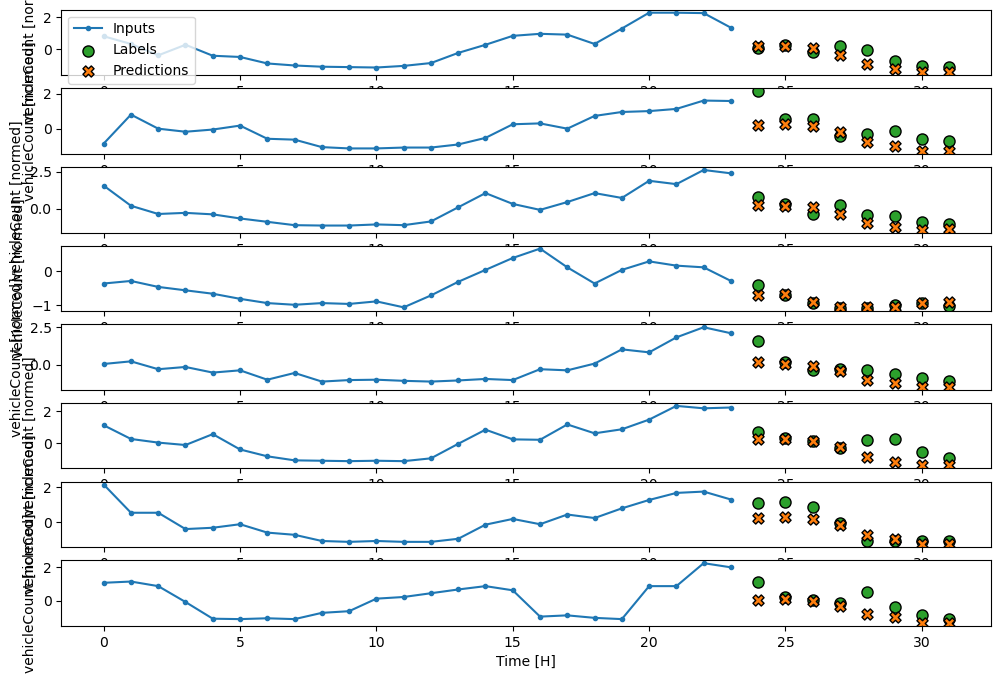

In [22]:
YT=[]
YP=[]
yt=[]
yp=[]
from sklearn.metrics import r2_score
t,p=multi_window.plot2(multi_lstm_model,max_subplots=10)
r2_score(t, p)

In [54]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [55]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [56]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [57]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 7])

In [58]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [59]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 7)


Epoch 1/1000
120/120 [==============================] - 52s 399ms/step - loss: 0.5714 - mean_absolute_error: 0.5508 - val_loss: 0.2848 - val_mean_absolute_error: 0.3588
Epoch 2/1000
120/120 [==============================] - 42s 348ms/step - loss: 0.3283 - mean_absolute_error: 0.3363 - val_loss: 0.2504 - val_mean_absolute_error: 0.3166
Epoch 3/1000
120/120 [==============================] - 40s 336ms/step - loss: 0.3179 - mean_absolute_error: 0.3207 - val_loss: 0.2439 - val_mean_absolute_error: 0.3093
Epoch 4/1000
120/120 [==============================] - 40s 329ms/step - loss: 0.3127 - mean_absolute_error: 0.3149 - val_loss: 0.2608 - val_mean_absolute_error: 0.3223
Epoch 5/1000
120/120 [==============================] - 40s 332ms/step - loss: 0.3088 - mean_absolute_error: 0.3131 - val_loss: 0.2380 - val_mean_absolute_error: 0.3027
Epoch 6/1000
120/120 [==============================] - 41s 338ms/step - loss: 0.3050 - mean_absolute_error: 0.3107 - val_loss: 0.2395 - val_mean_absolute_

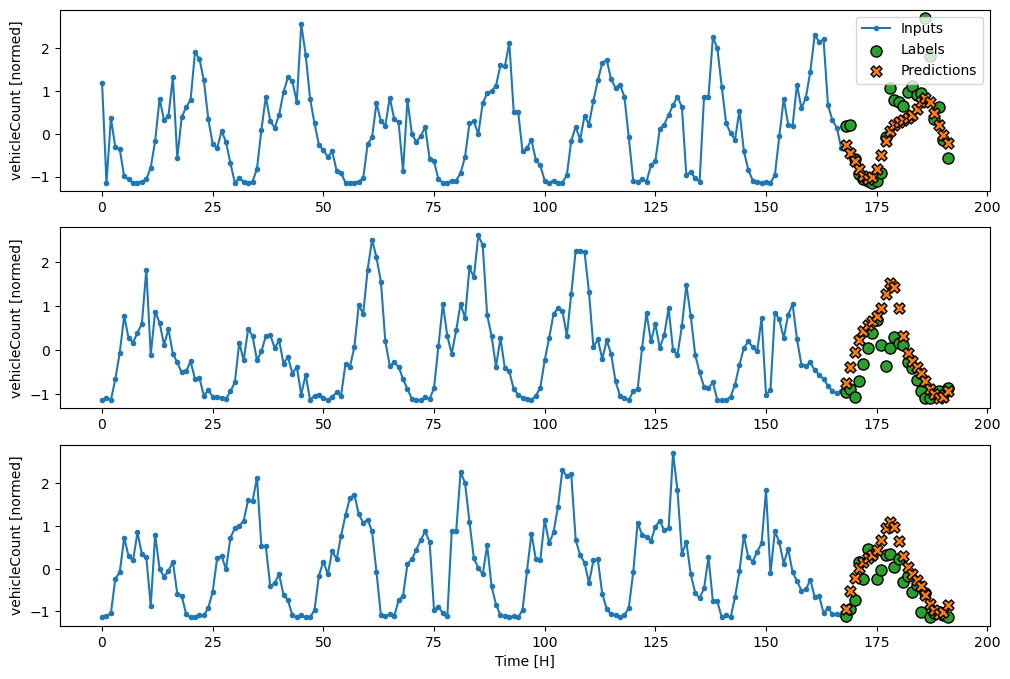

In [60]:
history = compile_and_fit(feedback_model, multi_window)


val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [77]:
ConvLSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1,168,7)),
    tf.keras.layers.ConvLSTM1D(filters=168, kernel_size=(1),input_shape=(1, 168, 7)),#, return_sequences=True),
    tf.keras.layers.Dense(units=168),
    tf.keras.layers.Dense(units=24),
    tf.keras.layers.Dense(units=1)])

In [78]:
history = compile_and_fit(ConvLSTM_model, wide_window)
val_performance['ConvLSTM'] = ConvLSTM_model.evaluate(wide_window.val)
performance['ConvLSTM'] = ConvLSTM_model.evaluate(wide_window.test, verbose=0)

Epoch 1/300


ValueError: in user code:

    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 168 and 24 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_8/dense_26/BiasAdd, IteratorGetNext:1)' with input shapes: [?,168,1], [?,24,1].


0.44267423658434846

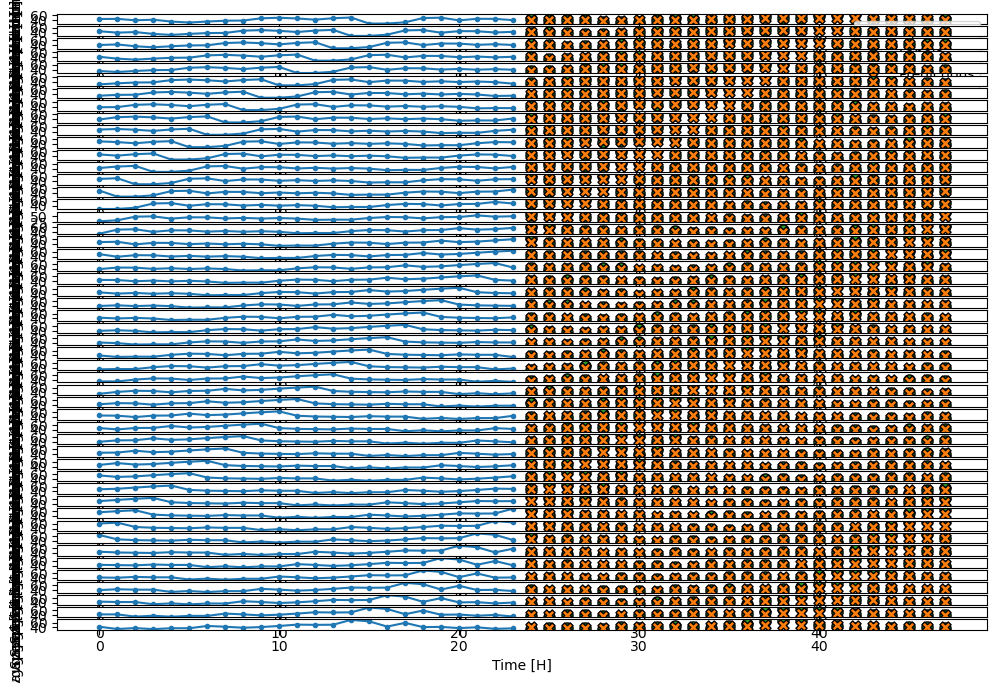

In [ ]:
YT=[]
YP=[]
yt=[]
yp=[]
from sklearn.metrics import r2_score
t,p=wide_window.plot2(ConvLSTM_model,max_subplots=50)
r2_score(t, p)

In [79]:
MAX_EPOCHS=200
Dlstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8),#diri ch7al 3andk f input hna
    tf.keras.layers.Dense(16),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=6),
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(Dlstm_model, wide_window)



val_performance['DLSTM'] = Dlstm_model.evaluate(wide_window.val)
performance['DLSTM'] = Dlstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(Dlstm_model)

Epoch 1/300


ValueError: in user code:

    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 168 and 24 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_9/dense_30/BiasAdd, IteratorGetNext:1)' with input shapes: [?,168,1], [?,24,1].


0.4690953944234022

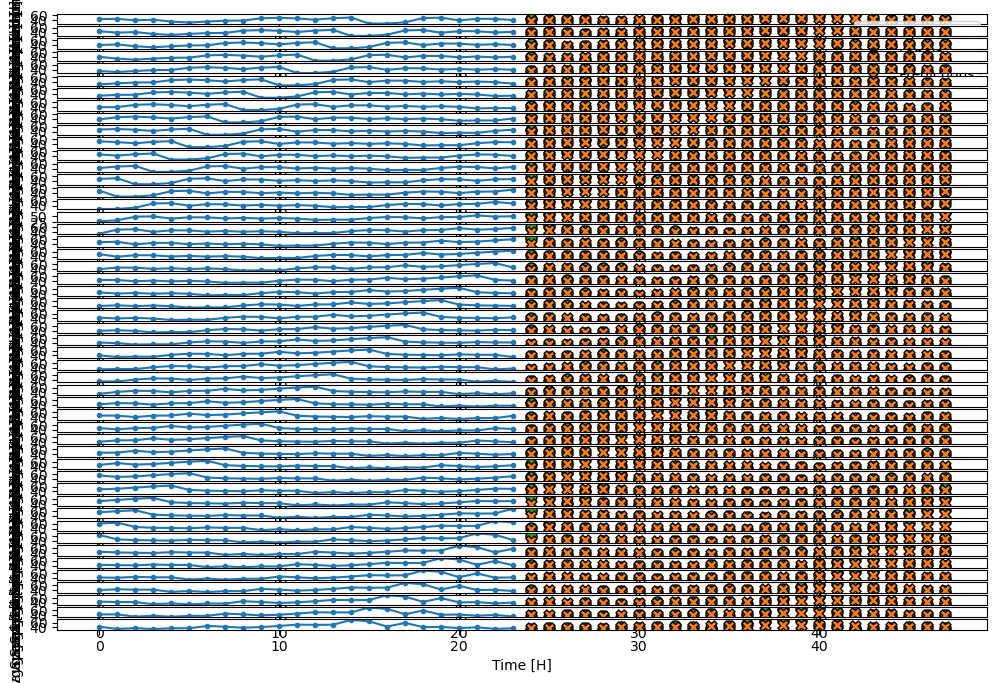

In [ ]:
YT=[]
YP=[]
yt=[]
yp=[]
from sklearn.metrics import r2_score
t,p=wide_window.plot2(Dlstm_model,max_subplots=50)
r2_score(t, p)

In [81]:
MAX_EPOCHS=200
lstm_model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=7),
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(lstm_model2, wide_window)



val_performance['LSTM'] = lstm_model2.evaluate(wide_window.val)
performance['LSTM'] = lstm_model2.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model2)

Epoch 1/300


ValueError: in user code:

    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ZIYAD\anaconda3\envs\nlp\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 168 and 24 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_11/dense_34/BiasAdd, IteratorGetNext:1)' with input shapes: [?,168,1], [?,24,1].


0.4400765836048087

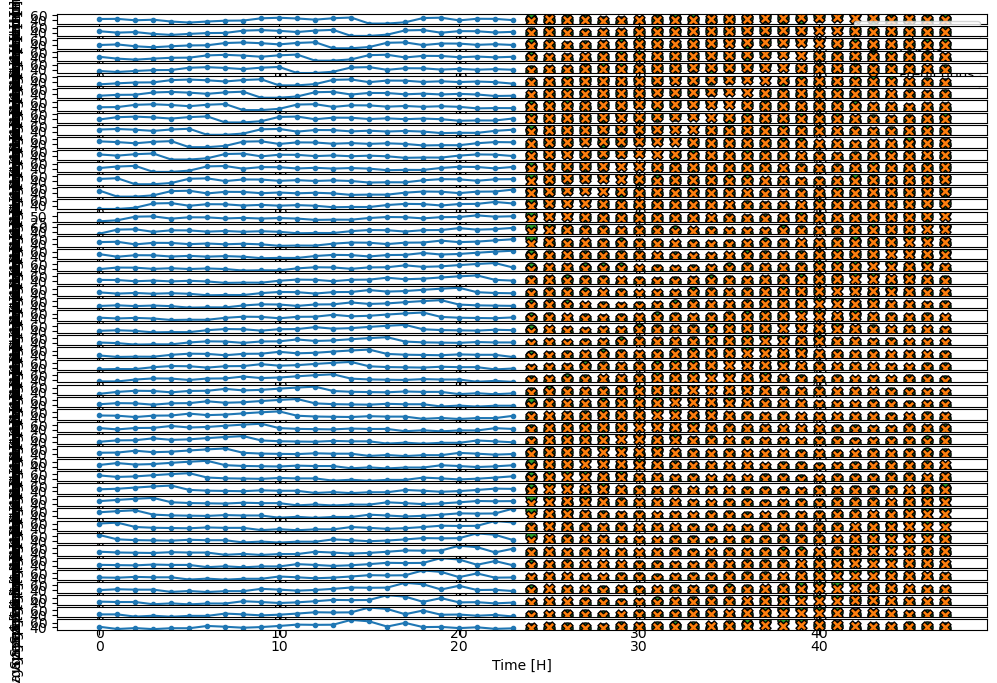

In [ ]:
YT=[]
YP=[]
yt=[]
yp=[]
from sklearn.metrics import r2_score
t,p=wide_window.plot2(lstm_model2,max_subplots=50)
r2_score(t, p)

n= 0
n= 1
n= 2


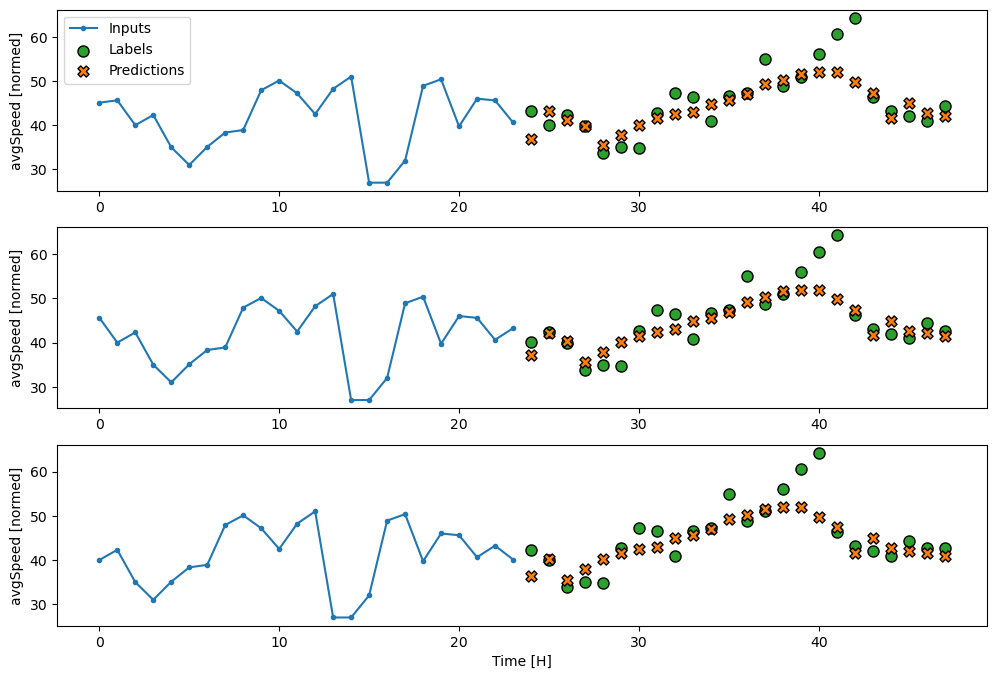

In [ ]:
wide_window.plot(lstm_model2)

n= 0
n= 1
n= 2


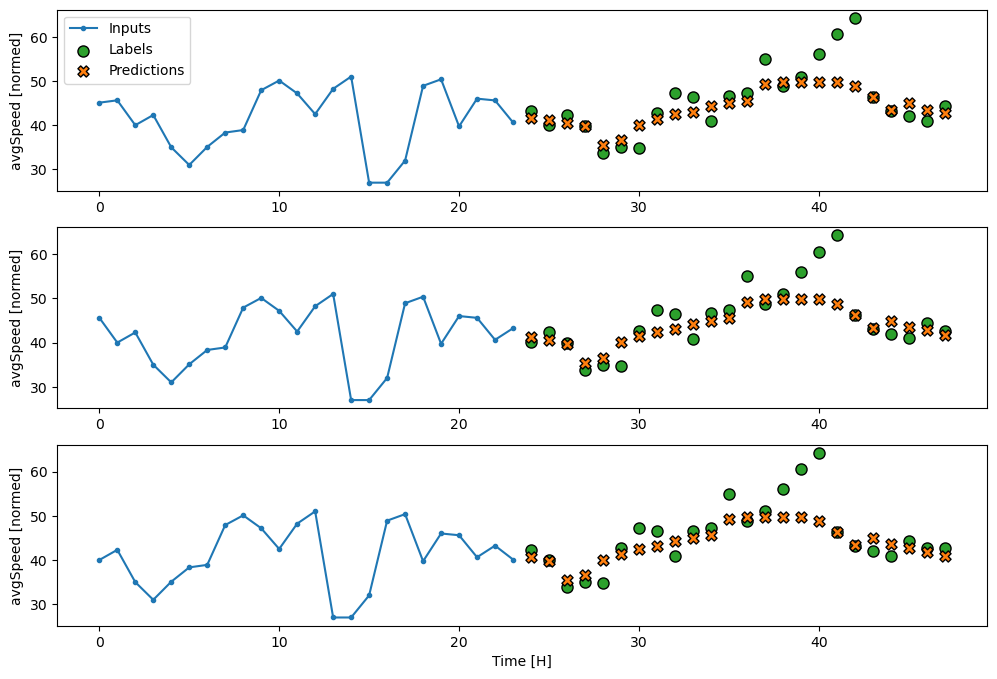

In [ ]:
wide_window.plot(ConvLSTM_model)

n= 0
n= 1
n= 2


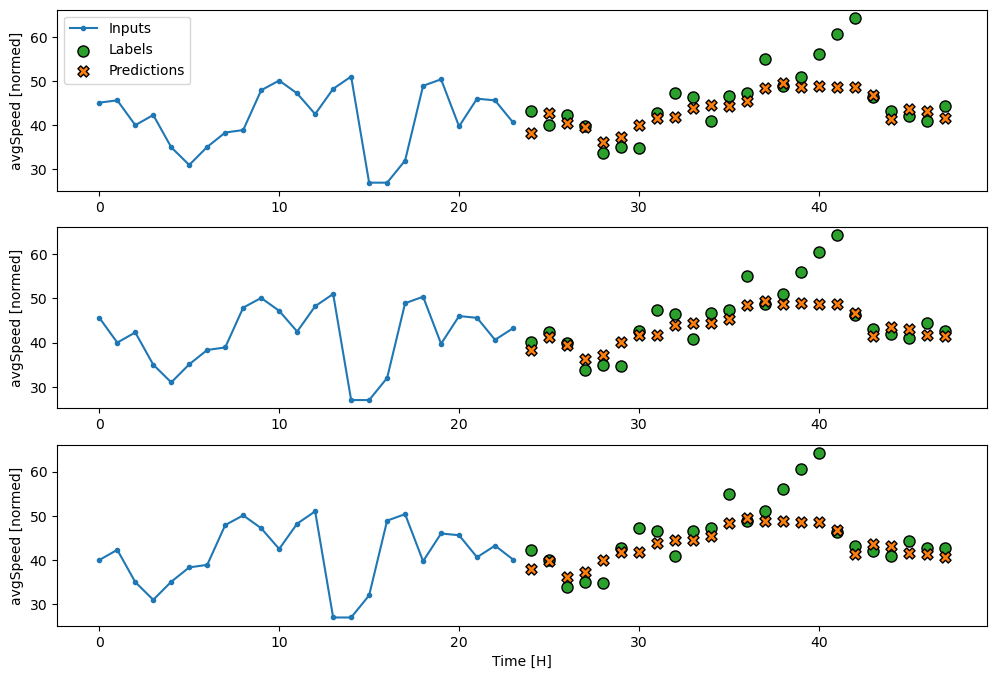

In [ ]:
wide_window.plot(Dlstm_model)

In [ ]:
import json
    
    
with open("val_performance(320).json", "w") as outfile:
    json.dump(val_performance, outfile)

with open("performance(320).json", "w") as outfile:
    json.dump(performance, outfile)

n= 0
n= 1
n= 2


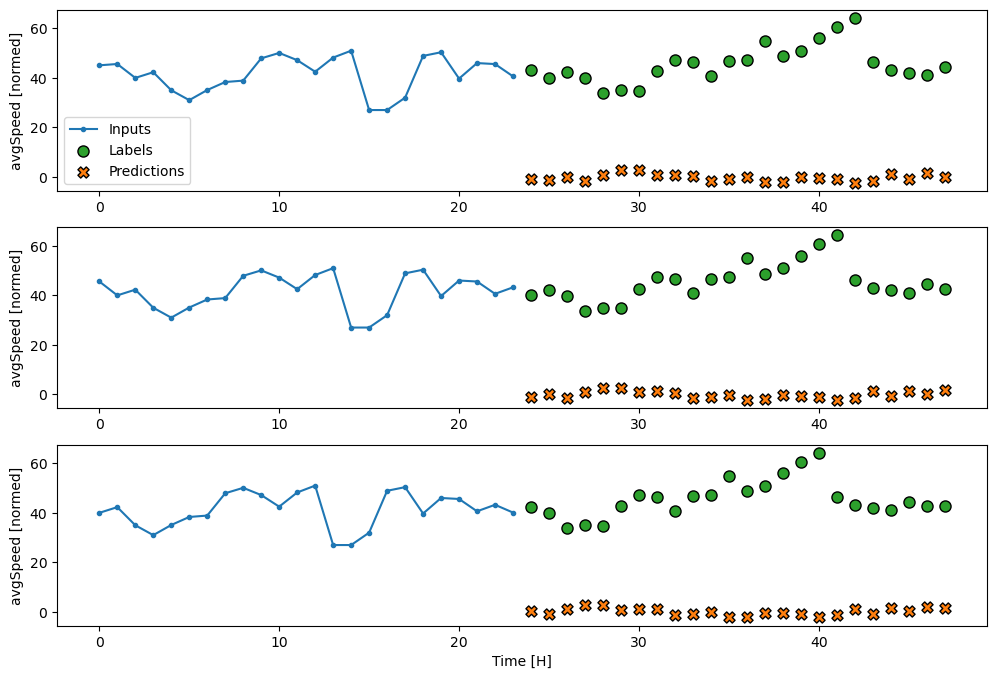

In [ ]:
wide_window.plot(model)

In [ ]:
scores = model.evaluate(wide_window.test)
scores

2/2 [==============================] - 0s 6ms/step - loss: 2097.1790 - mean_absolute_error: 44.8354


[2097.178955078125, 44.83543395996094]

In [ ]:
pree=[]
for i in range(3):
    pree.append(pd.DataFrame({'label': llabels[i], 'predictions': ppredictions[i]}, columns=['label', 'predictions']))

pren2=dnormal(pree[1])

NameError: name 'llabels' is not defined

In [ ]:
pren2.describe()

,label,predictions
count,24.000000,24.000000
mean,45.111805,44.600037
std,9.952848,7.694475
min,29.000000,36.004906
25%,39.708331,39.968636
50%,43.708332,42.596910
75%,47.775000,45.335145
max,79.500000,70.034225


In [ ]:
pren2.label.max()

79.5

In [ ]:
print("prediction de",len(pren2),"heure")
pren2.head()

prediction de 24 heure


,label,predictions
0,45.750000,42.714443
1,44.166664,43.762062
2,47.500000,45.897110
3,29.000000,42.470150
4,36.000000,40.113556


In [ ]:
from traffic_signal import *
from road import *
from curve import *
#from simulation import *
from vehicle import *
from vehicle_generator import *
from window import *
from simulation import Simulation
# Create simulation + data
sim = Simulation(pren2)
# Add multiple roads
sim.create_roads([
    ((-10, 108), (290, 108)),
    ((-10, 104), (290, 104)),

    ((290, 100), (-10, 100)),
    ((290, 96), (80, 96)),
    ((80, 96), (-10, 96)),
])
sim.create_gen({
    'vehicle_rate': 60,
    'vehicles': [
        [3, {"path": [0]}],
        [6, {"path": [1]}],
        
        [3, {"path": [3, 4]}],
        [6, {"path": [2]}],
    ]
})
# Start simulation
win = Window(sim)
win.offset = (-145, -95)
win.zoom = 8
win.run(steps_per_update=5)

pygame 2.2.0 (SDL 2.0.22, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html
self.vehicle_rate= 97
zham
self.vehicle_rate= 112
zham
self.vehicle_rate= 120
zham
self.vehicle_rate= 124
zham
zham
self.vehicle_rate= 130
zham
self.vehicle_rate= 125
zham
self.vehicle_rate= 135
self.vehicle_rate= 130
zham
zham
self.vehicle_rate= 129
zham
self.vehicle_rate= 101
zhamself.vehicle_rate= 110

self.vehicle_rate= 105
zham
zham
self.vehicle_rate= 113
zham
self.vehicle_rate= 126
zhamself.vehicle_rate= 102

self.vehicle_rate= 96
zham
zhamself.vehicle_rate= 24

nozham
self.vehicle_rate= 12
self.vehicle_rate= 106
zham
zham
self.vehicle_rate= 115


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model

In [ ]:
Y=[]
X=[]

for i in range(3):
    Y.append(df.avgSpeed[i:])
    X.append(df.iloc[:-i])

In [ ]:
y1=df.avgSpeed[1:]
df1=df.iloc[:-1]
x_train, x_test, y_train, y_test = train_test_split(df1, y1, test_size = 0.15,random_state=21)

In [ ]:
scoring = 'accuracy'
models= []
from sklearn.metrics import mean_absolute_error
models.append(('LR', LinearRegression()))
models.append(('SVM', SVR()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=48)))
results= names= tmodels= []
for name, model in models:
    names.append(name)
    msg = "For %s Model" % (name)
    print(msg)
    clf = model
    clf.fit(x_train, y_train)
    predict = clf.predict(x_test)
    accuracy = clf.score(x_test, y_test)
    mae= mean_absolute_error(y_test, predict)
    print("Test Accuracy:",accuracy)
    print("mean_absolute_error:", mae)
    tmodels.append(clf)
    print("*******************************************************************")

For LR Model
Test Accuracy: 0.2942971850242877
mean_absolute_error: 0.5955254996157099
*******************************************************************
For SVM Model
Test Accuracy: 0.3161881241739587
mean_absolute_error: 0.570021892823394
*******************************************************************
For KNN Model
Test Accuracy: 0.3172695503359565
mean_absolute_error: 0.5776149102246894
*******************************************************************


In [ ]:

iinputs=[]
labels=[]
predic=[]

import random

randomlist = random.sample(range(10, int(len(y_test) - 10)), 3)

for i in range(3):
    y1=df.avgSpeed[i+1:]
    df1=df.iloc[:-i-1]
    x_train, x_test, y_train, y_test = train_test_split(df1, y1, test_size = 0.20,random_state=21)
    y_test= y_test.tolist()

    scoring = 'accuracy'
    models= []
    models.append(('LR', LinearRegression()))
    models.append(('SVM', SVR()))
    models.append(('KNN', KNeighborsRegressor(n_neighbors=48)))
    results= names= tmodels= []
    for name, model in models:
        names.append(name)
        msg = "For %s Model" % (name)
        print(msg)
        clf = model
        clf.fit(x_train, y_train)
        predict = clf.predict(x_test)

        iinputs.append(randomlist[i])
        labels.append(y_test[randomlist[i]])
        predic.append(predict[randomlist[i]])

        accuracy = clf.score(x_test, y_test)
        print("Test Accuracy:",accuracy)
        tmodels.append(clf)
        print("*******************************************************************")
    
    

For LR Model
Test Accuracy: 0.41672933108977706
*******************************************************************
For SVM Model
Test Accuracy: 0.4659953185753001
*******************************************************************
For KNN Model
Test Accuracy: 0.4432577411614833
*******************************************************************
For LR Model
Test Accuracy: 0.3223165104885629
*******************************************************************
For SVM Model
Test Accuracy: 0.38226477689693705
*******************************************************************
For KNN Model
Test Accuracy: 0.3692081353165504
*******************************************************************
For LR Model
Test Accuracy: 0.2942971850242877
*******************************************************************
For SVM Model
Test Accuracy: 0.3161881241739587
*******************************************************************
For KNN Model
Test Accuracy: 0.3172695503359565
*************************

n= 0


NameError: name 'input_indices' is not defined

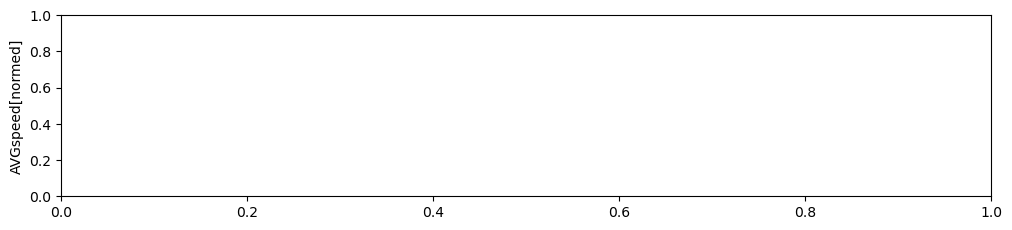

In [ ]:




inputs = iinputs
labels = labels
plt.figure(figsize=(12, 8))


ppre=[]
llabels=[]

for n in range(3):
    print("n=",n)
    plt.subplot(3, 1, n+1)
    plt.ylabel('AVGspeed[normed]')
    plt.plot(input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if label_columns:
      label_col_index = label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    
    llabels.append(labels[n, :, label_col_index])
    plt.scatter(label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      ppre.append(predictions[n, :, label_col_index])
      plt.scatter(label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

plt.xlabel('Time [H]')